# Group Classification (ZenML)

Train the group classifier with the updated pipeline structure.

In [1]:
from pathlib import Path
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.training import group_classification_pipeline

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).


In [2]:
# Parquet inputs. Edit this list to point at the files you want to train on.
data_dir = Path(PROJECT_ROOT) / "data"
parquet_paths = sorted(data_dir.glob("ml_output_*.parquet"))

# Example: uncomment to select a smaller subset
# parquet_paths = parquet_paths[:1]

parquet_paths = [str(p) for p in parquet_paths]
if not parquet_paths:
    raise RuntimeError(f"No parquet files found in {data_dir}")


In [3]:
# Run the pipeline
base_loader_config = {
    "mode": "train",
    #"batch_size": 64, #Forces a batch size, keep off to use HPO's best choice
    "chunk_row_groups": 4,
    "chunk_workers": 0,
    "train_fraction": 0.80,
    "val_fraction": 0.10,
    "test_fraction": 0.10,
    "split_seed": 0,
}

run = group_classification_pipeline.with_options(enable_cache=False)(
    parquet_paths=parquet_paths,
    pipeline_config={
        "loader": {
            # Loader step now only validates paths/schema and carries source paths.
            "config_json": {"mode": "train"}
        },
        "hpo": {
            "enabled": True,
            "n_trials": 128,
            "max_epochs": 10,
            "early_stopping": {
                "enabled": True,
                "monitor": "val_loss",
                "mode": "min",
                "patience": 2,
                "min_delta": 0.001,
            },
            "compile": {"enabled": False, "mode": "reduce-overhead"},
            "storage": f"sqlite:///{PROJECT_ROOT}/.optuna/group_classifier_hpo.db",
            "loader_config": {
                "base": dict(base_loader_config),
                "train": {"split": "train", "sample_fraction": 0.1},
                "val": {"split": "val", "sample_fraction": 0.1},
            },
        },
        "train": {
            "max_epochs": 25,
            "early_stopping": {
                "enabled": True,
                "monitor": "val_loss",
                "mode": "min",
                "patience": 5,
                "min_delta": 0.0005,
            },
            "compile": {"enabled": True, "mode": "reduce-overhead"},
            "loader_config": {
                "base": dict(base_loader_config),
                "train": {"split": "train", "sample_fraction": None},
                "val": {"split": "val", "sample_fraction": None},
            },
        },
        "evaluate": {
            "threshold": 0.5,
            "loader_config": {
                "base": dict(base_loader_config),
                "evaluate": {"split": "test", "sample_fraction": None},
            },
        },
        "export": {
            "prefer_cuda": True,
            "export_dir": str(PROJECT_ROOT / "trained_models" / "groupclassifier"),
        },
    },
)

trained_module = load_step_output(run, "train_group_classifier")
metrics = load_step_output(run, "evaluate_group_classifier")
export = load_step_output(run, "export_group_classifier")

print("metrics:", metrics)
print("export:", export)


Initiating a new run for the pipeline: group_classification_pipeline.
Caching is disabled by default for group_classification_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step tune_group_classifier has started.


[I 2026-02-16 02:39:33,383] Using an existing study with name 'group_classifier_hpo' instead of creating a new one.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:40:02,041] Trial 74 finished with value: 0.06170429259260989 and parameters: {'lr': 0.00029202013837875684, 'weight_decay': 1.3068151303101493e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.22089854173865792}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:40:26,562] Trial 75 finished with value: 0.0826733338166468 and parameters: {'lr': 0.00035131494666318976, 'weight_decay': 2.5636914302503892e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.2083196886674262}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:40:47,459] Trial 76 finished with value: 0.06472557710240716 and parameters: {'lr': 0.00043155236085512386, 'weight_decay': 5.177215138531179e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 210, 'num_blocks': 2, 'dropout': 0.18992022446816123}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  651 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 651 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 651 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:41:06,290] Trial 77 finished with value: 0.07931497417714285 and parameters: {'lr': 0.002141463574040592, 'weight_decay': 2.0274903846507763e-05, 'batch_size_exp': 5, 'heads': 3, 'hidden': 204, 'num_blocks': 1, 'dropout': 0.06930586274332706}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.7 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:41:32,283] Trial 78 finished with value: 0.0680593879581053 and parameters: {'lr': 0.00020507934877430205, 'weight_decay': 8.114141386666103e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'num_blocks': 4, 'dropout': 0.1767210801477008}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:41:55,200] Trial 79 finished with value: 0.060918204220277924 and parameters: {'lr': 0.0001609618061460677, 'weight_decay': 4.038241415210149e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 135, 'num_blocks': 3, 'dropout': 0.23410683441201205}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:42:20,890] Trial 80 finished with value: 0.06517930279532158 and parameters: {'lr': 0.0010602106526984788, 'weight_decay': 1.1169305270869258e-05, 'batch_size_exp': 5, 'heads': 8, 'hidden': 176, 'num_blocks': 4, 'dropout': 0.22082145244254317}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:42:43,831] Trial 81 finished with value: 0.05690286866163615 and parameters: {'lr': 0.0002602120665742925, 'weight_decay': 1.6828737292129054e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 186, 'num_blocks': 3, 'dropout': 0.2557331603380735}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:42:57,671] Trial 82 finished with value: 0.05956411864087911 and parameters: {'lr': 0.001671075855562531, 'weight_decay': 7.7152485489168e-05, 'batch_size_exp': 6, 'heads': 6, 'hidden': 168, 'num_blocks': 4, 'dropout': 0.16813637284621133}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.1 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:43:21,969] Trial 83 finished with value: 0.06307100013523183 and parameters: {'lr': 0.0005424781692455893, 'weight_decay': 1.2563083221749252e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 198, 'num_blocks': 4, 'dropout': 0.22768550475921018}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.9 M                                                                                                
Total estimated model params size (MB): 19                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:43:48,206] Trial 84 finished with value: 0.0914761374895432 and parameters: {'lr': 0.000635571490841697, 'weight_decay': 7.773609125065378e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 216, 'num_blocks': 4, 'dropout': 0.22082696745499547}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:44:11,740] Trial 85 finished with value: 0.08327075009529265 and parameters: {'lr': 0.00037204728915204933, 'weight_decay': 1.3708465033005964e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 196, 'num_blocks': 4, 'dropout': 0.08614206203109852}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.6 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:44:36,563] Trial 86 finished with value: 0.052704548931778956 and parameters: {'lr': 0.0005039266579805553, 'weight_decay': 1.0542885671145613e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 125, 'num_blocks': 4, 'dropout': 0.26495978414183075}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:45:00,841] Trial 87 finished with value: 0.07259910229755484 and parameters: {'lr': 0.0008478648255732385, 'weight_decay': 2.7456384367850695e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.20384647807768952}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:45:26,250] Trial 88 finished with value: 0.0758840082595067 and parameters: {'lr': 0.0003066854565079313, 'weight_decay': 2.3019564374277077e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 204, 'num_blocks': 4, 'dropout': 0.19258771544904446}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:45:52,275] Trial 89 finished with value: 0.05127438347532142 and parameters: {'lr': 0.00041108785803976747, 'weight_decay': 0.00010506766648878422, 'batch_size_exp': 5, 'heads': 7, 'hidden': 154, 'num_blocks': 4, 'dropout': 0.25139133019782306}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:46:12,850] Trial 90 finished with value: 0.06344235662995658 and parameters: {'lr': 0.0006428753485348156, 'weight_decay': 1.7964663609111885e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 186, 'num_blocks': 2, 'dropout': 0.2155158813494505}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:46:35,224] Trial 91 finished with value: 0.07994450835846596 and parameters: {'lr': 0.0007729342245051175, 'weight_decay': 8.89162242135315e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'num_blocks': 3, 'dropout': 0.2455096718323122}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.0 M                                                                                                
Total estimated model params size (MB): 24                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:46:59,910] Trial 92 finished with value: 0.04992184436284237 and parameters: {'lr': 0.00045811862139759466, 'weight_decay': 3.161294663616325e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 240, 'num_blocks': 4, 'dropout': 0.06137856171756445}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  248 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 248 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 248 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:47:20,862] Trial 93 finished with value: 0.06247968867606258 and parameters: {'lr': 0.0005738398246160425, 'weight_decay': 1.4792457501114312e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 80, 'num_blocks': 2, 'dropout': 0.042261417881954665}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  164 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 164 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 164 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:47:41,808] Trial 94 finished with value: 0.07432428893187772 and parameters: {'lr': 0.0004990583044069211, 'weight_decay': 3.968426516439984e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 65, 'num_blocks': 2, 'dropout': 0.05547532574370315}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  401 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 401 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 401 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:48:02,129] Trial 95 finished with value: 0.061398117855098674 and parameters: {'lr': 0.000962450155871237, 'weight_decay': 1.1719554042660709e-05, 'batch_size_exp': 5, 'heads': 2, 'hidden': 102, 'num_blocks': 2, 'dropout': 0.02906701906094457}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  299 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 299 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 299 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:48:22,428] Trial 96 finished with value: 0.057641245181793754 and parameters: {'lr': 0.0012486085789144745, 'weight_decay': 2.0520928051781406e-05, 'batch_size_exp': 5, 'heads': 4, 'hidden': 88, 'num_blocks': 2, 'dropout': 0.008009606783801332}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:48:42,848] Trial 97 finished with value: 0.0683545812224009 and parameters: {'lr': 0.0004015775802230345, 'weight_decay': 6.912708092533435e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 174, 'num_blocks': 2, 'dropout': 0.1989838788462116}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.5 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:49:08,135] Trial 98 finished with value: 0.07403054645990734 and parameters: {'lr': 0.0006767058469589395, 'weight_decay': 5.70695172100087e-06, 'batch_size_exp': 5, 'heads': 4, 'hidden': 208, 'num_blocks': 4, 'dropout': 0.01752688119985151}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:49:31,681] Trial 99 finished with value: 0.0656902640479507 and parameters: {'lr': 0.000366258768624586, 'weight_decay': 1.5390086043200874e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 165, 'num_blocks': 3, 'dropout': 0.13636745075447593}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:49:52,439] Trial 100 finished with value: 0.06521369773686303 and parameters: {'lr': 0.00024242805810808322, 'weight_decay': 2.3997349511047515e-05, 'batch_size_exp': 5, 'heads': 2, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.10278283933493249}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  519 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 519 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:50:10,447] Trial 101 finished with value: 0.053003109702319834 and parameters: {'lr': 0.0007498954147263401, 'weight_decay': 6.264334524462631e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 182, 'num_blocks': 1, 'dropout': 0.07892305656967046}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:50:35,246] Trial 102 finished with value: 0.0678767931433568 and parameters: {'lr': 0.00034703719900828193, 'weight_decay': 5.060828967722429e-05, 'batch_size_exp': 5, 'heads': 3, 'hidden': 177, 'num_blocks': 4, 'dropout': 0.23910388711074684}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:50:44,450] Trial 103 finished with value: 0.6471198845353926 and parameters: {'lr': 0.009675906634398648, 'weight_decay': 3.0078270045092613e-05, 'batch_size_exp': 7, 'heads': 8, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.019218066032735105}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.4 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:50:53,730] Trial 104 finished with value: 0.08142193008838973 and parameters: {'lr': 0.006592447295813125, 'weight_decay': 8.651830679601826e-06, 'batch_size_exp': 7, 'heads': 8, 'hidden': 248, 'num_blocks': 4, 'dropout': 0.03825835902844902}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  5.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 5.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.2 M                                                                                                
Total estimated model params size (MB): 20                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:51:07,325] Trial 105 finished with value: 0.08375762424992848 and parameters: {'lr': 0.002757586734937463, 'weight_decay': 1.768640892297202e-05, 'batch_size_exp': 6, 'heads': 8, 'hidden': 224, 'num_blocks': 4, 'dropout': 0.00739060922673169}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  5.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 5.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.7 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:51:16,147] Trial 106 finished with value: 0.06920017755549887 and parameters: {'lr': 0.0033588242989220393, 'weight_decay': 4.5684429706293326e-05, 'batch_size_exp': 7, 'heads': 6, 'hidden': 234, 'num_blocks': 4, 'dropout': 0.0017581962949890534}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:51:30,697] Trial 107 finished with value: 0.06443785610521988 and parameters: {'lr': 0.0005343900396420561, 'weight_decay': 1.0027985250030374e-05, 'batch_size_exp': 6, 'heads': 7, 'hidden': 168, 'num_blocks': 4, 'dropout': 0.2101657311721083}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  934 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 934 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 934 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:51:50,009] Trial 108 finished with value: 0.05888758028238456 and parameters: {'lr': 0.0008679125505019551, 'weight_decay': 1.3424493866400409e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 156, 'num_blocks': 2, 'dropout': 0.15382966269610923}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:52:15,776] Trial 109 finished with value: 0.08307270161946367 and parameters: {'lr': 0.00480467165913521, 'weight_decay': 3.41272092762583e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 140, 'num_blocks': 4, 'dropout': 0.278774866961897}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.9 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:52:23,095] Trial 110 finished with value: 0.07832483336422014 and parameters: {'lr': 0.0006038019934279562, 'weight_decay': 2.0262333806362675e-05, 'batch_size_exp': 7, 'heads': 8, 'hidden': 168, 'num_blocks': 3, 'dropout': 0.23044863097660506}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:52:48,981] Trial 111 finished with value: 0.111264734719851 and parameters: {'lr': 0.007645014213652496, 'weight_decay': 0.00036688019163322273, 'batch_size_exp': 5, 'heads': 6, 'hidden': 150, 'num_blocks': 4, 'dropout': 0.014420153501236793}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:53:09,744] Trial 112 finished with value: 0.06139187277612849 and parameters: {'lr': 0.00046053383866644494, 'weight_decay': 1.14944412445875e-06, 'batch_size_exp': 5, 'heads': 4, 'hidden': 172, 'num_blocks': 2, 'dropout': 0.17932095416213198}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:53:35,235] Trial 113 finished with value: 0.059138234143625505 and parameters: {'lr': 0.00042557393171834516, 'weight_decay': 2.9822293090043444e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 210, 'num_blocks': 4, 'dropout': 0.22289962083663023}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.1 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:54:01,615] Trial 114 finished with value: 0.06560824089538977 and parameters: {'lr': 0.00028440923262585397, 'weight_decay': 1.4463727277905662e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 198, 'num_blocks': 4, 'dropout': 0.18677802096634502}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.9 M                                                                                                
Total estimated model params size (MB): 19                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:54:26,687] Trial 115 finished with value: 0.09756809986711289 and parameters: {'lr': 0.0039536148386858806, 'weight_decay': 1.6920542145318033e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 217, 'num_blocks': 4, 'dropout': 0.19682438649415068}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:54:51,812] Trial 116 finished with value: 0.07003068368627417 and parameters: {'lr': 0.0003216652575813808, 'weight_decay': 2.09895070547561e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.2057200250553113}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:55:17,459] Trial 117 finished with value: 0.050415002573165835 and parameters: {'lr': 0.0005742163026482237, 'weight_decay': 2.7079913720898066e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.21516864837408964}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:55:42,400] Trial 118 finished with value: 0.057420618056973315 and parameters: {'lr': 0.0005009905764530827, 'weight_decay': 1.2246364850437012e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 203, 'num_blocks': 4, 'dropout': 0.19156272642292332}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.6 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:56:07,548] Trial 119 finished with value: 0.0940404940998147 and parameters: {'lr': 0.0018822951417977714, 'weight_decay': 1.5395950249720525e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 186, 'num_blocks': 4, 'dropout': 0.11351089808222664}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.0 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:56:27,676] Trial 120 finished with value: 0.05844559025320207 and parameters: {'lr': 0.0007042264117795081, 'weight_decay': 2.3013707123034143e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 228, 'num_blocks': 2, 'dropout': 0.1740382757385461}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.5 M                                                                                                
Total estimated model params size (MB): 26                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:56:41,991] Trial 121 finished with value: 0.0689003963011855 and parameters: {'lr': 0.0014001526345276878, 'weight_decay': 3.722108327176179e-05, 'batch_size_exp': 6, 'heads': 5, 'hidden': 250, 'num_blocks': 4, 'dropout': 0.28725156877646113}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:57:04,765] Trial 122 finished with value: 0.06286193221020772 and parameters: {'lr': 0.00039020929536907596, 'weight_decay': 6.660729563676017e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'num_blocks': 3, 'dropout': 0.22434100068615265}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:57:29,678] Trial 123 finished with value: 0.06032692712749013 and parameters: {'lr': 0.0002961599342505141, 'weight_decay': 2.522883475983237e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 174, 'num_blocks': 4, 'dropout': 0.21664074205463124}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:57:53,901] Trial 124 finished with value: 0.07121526737992438 and parameters: {'lr': 0.00025005846519688475, 'weight_decay': 6.3121944045571214e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 168, 'num_blocks': 4, 'dropout': 0.2091042179400529}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.2 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:58:19,107] Trial 125 finished with value: 0.05490370477717486 and parameters: {'lr': 0.0003517018913965725, 'weight_decay': 9.759284593934635e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 144, 'num_blocks': 4, 'dropout': 0.022872296453603717}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:58:43,454] Trial 126 finished with value: 0.05616338925887339 and parameters: {'lr': 0.0001923229080865666, 'weight_decay': 1.1427827698961468e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 114, 'num_blocks': 4, 'dropout': 0.297800117651637}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:59:08,431] Trial 127 finished with value: 0.07714968332037422 and parameters: {'lr': 0.00044731257422601673, 'weight_decay': 3.7144352625542655e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 164, 'num_blocks': 4, 'dropout': 0.2010353818805848}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:59:27,844] Trial 128 finished with value: 0.06524447227903404 and parameters: {'lr': 0.0002741901872821705, 'weight_decay': 7.281214866441531e-06, 'batch_size_exp': 5, 'heads': 3, 'hidden': 243, 'num_blocks': 2, 'dropout': 0.27127012521105803}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 02:59:52,678] Trial 129 finished with value: 0.08134802062966809 and parameters: {'lr': 0.0008101102710322245, 'weight_decay': 5.505468258680928e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 156, 'num_blocks': 4, 'dropout': 0.16613089303209483}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:00:18,082] Trial 130 finished with value: 0.07701518500559264 and parameters: {'lr': 0.0010241308093956359, 'weight_decay': 8.563105640501744e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.23445094262857596}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  630 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 630 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 630 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:00:37,341] Trial 131 finished with value: 0.07597726045511895 and parameters: {'lr': 0.000639517136090568, 'weight_decay': 1.786635241216141e-05, 'batch_size_exp': 5, 'heads': 8, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.20479241931922285}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:01:03,222] Trial 132 finished with value: 0.06431800597029165 and parameters: {'lr': 0.0005406305170640092, 'weight_decay': 4.899206246439738e-06, 'batch_size_exp': 5, 'heads': 3, 'hidden': 171, 'num_blocks': 4, 'dropout': 0.1814499194284861}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:01:25,272] Trial 133 finished with value: 0.07498511419810863 and parameters: {'lr': 0.0009315139442187967, 'weight_decay': 1.239683376884979e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 189, 'num_blocks': 3, 'dropout': 0.15929861288896854}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:01:48,111] Trial 134 finished with value: 0.05715135149715572 and parameters: {'lr': 0.0011448698597297483, 'weight_decay': 1.1074949677560469e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 182, 'num_blocks': 3, 'dropout': 0.2616851059503418}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:02:10,717] Trial 135 finished with value: 0.05313368540210939 and parameters: {'lr': 0.0007436789780570247, 'weight_decay': 1.3283137131614245e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 175, 'num_blocks': 3, 'dropout': 0.1964659782971898}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:02:32,552] Trial 136 finished with value: 0.059028452389543844 and parameters: {'lr': 0.0006808304632961574, 'weight_decay': 1.4926497607871879e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'num_blocks': 3, 'dropout': 0.16897154857933236}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.7 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:02:54,959] Trial 137 finished with value: 0.05974601592104998 and parameters: {'lr': 0.0008474221792677353, 'weight_decay': 7.580080733079832e-06, 'batch_size_exp': 5, 'heads': 5, 'hidden': 200, 'num_blocks': 3, 'dropout': 0.21809200477680757}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:03:17,020] Trial 138 finished with value: 0.0868543180064385 and parameters: {'lr': 0.0004787487805286937, 'weight_decay': 2.6158394772347444e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.186907181499786}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:03:42,598] Trial 139 finished with value: 0.05507294390558826 and parameters: {'lr': 0.000396455868215896, 'weight_decay': 4.294566933944764e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 98, 'num_blocks': 4, 'dropout': 0.24960921348453535}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:04:05,083] Trial 140 finished with value: 0.054160479409909396 and parameters: {'lr': 0.0003343265161503272, 'weight_decay': 9.052955586923056e-06, 'batch_size_exp': 5, 'heads': 5, 'hidden': 185, 'num_blocks': 2, 'dropout': 0.030933851877976648}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.5 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:04:32,091] Trial 141 finished with value: 0.05670455591001126 and parameters: {'lr': 0.0005899412939641071, 'weight_decay': 2.0400006665546344e-05, 'batch_size_exp': 5, 'heads': 8, 'hidden': 208, 'num_blocks': 4, 'dropout': 0.21286433109258085}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  5.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 5.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.2 M                                                                                                
Total estimated model params size (MB): 20                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:04:58,544] Trial 142 finished with value: 0.05563471214093777 and parameters: {'lr': 0.00022489632286643978, 'weight_decay': 1.0015745289078389e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 222, 'num_blocks': 4, 'dropout': 0.23896572153345888}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:05:11,122] Trial 143 finished with value: 0.05319170580355462 and parameters: {'lr': 0.0006145987379907404, 'weight_decay': 0.00017774909055070834, 'batch_size_exp': 6, 'heads': 3, 'hidden': 177, 'num_blocks': 3, 'dropout': 0.0004847583222199564}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:05:24,734] Trial 144 finished with value: 0.048496662066404864 and parameters: {'lr': 0.0005381680336491879, 'weight_decay': 0.00016497551888847544, 'batch_size_exp': 6, 'heads': 4, 'hidden': 184, 'num_blocks': 3, 'dropout': 0.14581793101064067}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:05:33,045] Trial 145 finished with value: 0.055736509145972155 and parameters: {'lr': 0.0007083326835685055, 'weight_decay': 0.00031553047949645075, 'batch_size_exp': 7, 'heads': 4, 'hidden': 188, 'num_blocks': 3, 'dropout': 0.1346906806897449}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.6 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:05:40,779] Trial 146 finished with value: 0.05353354021721745 and parameters: {'lr': 0.00041764618748248996, 'weight_decay': 0.0007669578753062435, 'batch_size_exp': 7, 'heads': 4, 'hidden': 196, 'num_blocks': 3, 'dropout': 0.13072514764772186}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.0 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:06:03,391] Trial 147 finished with value: 0.0835043777196859 and parameters: {'lr': 0.0006373863913835116, 'weight_decay': 1.6901708561855978e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 170, 'num_blocks': 3, 'dropout': 0.14962247568348824}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:06:14,728] Trial 148 finished with value: 0.0599397291307864 and parameters: {'lr': 0.000795568389384103, 'weight_decay': 0.0003876407707142847, 'batch_size_exp': 6, 'heads': 5, 'hidden': 165, 'num_blocks': 2, 'dropout': 0.12036431485983756}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  547 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 547 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 547 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:06:40,430] Trial 149 finished with value: 0.05125613309304166 and parameters: {'lr': 0.0004903198232296251, 'weight_decay': 0.00023330217812725352, 'batch_size_exp': 5, 'heads': 6, 'hidden': 72, 'num_blocks': 4, 'dropout': 0.14087630035633766}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.3 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:07:06,150] Trial 150 finished with value: 0.07021622233648107 and parameters: {'lr': 0.0022465084352622467, 'weight_decay': 6.4443384169697e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 178, 'num_blocks': 4, 'dropout': 0.09416780597268715}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:07:26,165] Trial 151 finished with value: 0.07053491306601103 and parameters: {'lr': 0.0003048076782238843, 'weight_decay': 9.401601816921102e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.047270185354499394}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:07:50,038] Trial 152 finished with value: 0.06898253855312833 and parameters: {'lr': 0.0005714633541767688, 'weight_decay': 3.071542510502925e-05, 'batch_size_exp': 5, 'heads': 4, 'hidden': 148, 'num_blocks': 3, 'dropout': 0.15446455888333155}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:08:15,494] Trial 153 finished with value: 0.05389582328729748 and parameters: {'lr': 0.00014142518352656787, 'weight_decay': 8.169599134638173e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 175, 'num_blocks': 4, 'dropout': 0.2273476542359306}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.7 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:08:42,048] Trial 154 finished with value: 0.05678757698917241 and parameters: {'lr': 0.00011317841807961932, 'weight_decay': 1.0337707958453896e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 161, 'num_blocks': 4, 'dropout': 0.28274163958596965}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:09:07,727] Trial 155 finished with value: 0.06897031022987751 and parameters: {'lr': 0.0001587076777023954, 'weight_decay': 3.35768161238337e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 168, 'num_blocks': 4, 'dropout': 0.161197519251996}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:09:33,859] Trial 156 finished with value: 0.04864159863881813 and parameters: {'lr': 0.0004382855518359692, 'weight_decay': 2.4135199466328323e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 203, 'num_blocks': 4, 'dropout': 0.2583681365402691}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:10:00,594] Trial 157 finished with value: 0.059078473181272885 and parameters: {'lr': 0.0010738859246693206, 'weight_decay': 1.3716703258819211e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 154, 'num_blocks': 4, 'dropout': 0.009043541574886549}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:10:26,255] Trial 158 finished with value: 0.055785909182282156 and parameters: {'lr': 0.0003749637546053118, 'weight_decay': 1.1305794282004627e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.2107846426973026}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.9 M                                                                                                
Total estimated model params size (MB): 19                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:10:52,039] Trial 159 finished with value: 0.35891274820943797 and parameters: {'lr': 0.005665847016990853, 'weight_decay': 4.621023471607507e-06, 'batch_size_exp': 5, 'heads': 8, 'hidden': 216, 'num_blocks': 4, 'dropout': 0.17483612891266195}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  5.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 5.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.7 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:11:05,899] Trial 160 finished with value: 0.05976113609923339 and parameters: {'lr': 0.0008647606141373053, 'weight_decay': 4.331342165696836e-05, 'batch_size_exp': 6, 'heads': 6, 'hidden': 234, 'num_blocks': 4, 'dropout': 0.24383256645084345}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  320 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 320 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 320 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:11:26,487] Trial 161 finished with value: 0.0749592303026537 and parameters: {'lr': 0.000526432628854634, 'weight_decay': 5.814375162931224e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 91, 'num_blocks': 2, 'dropout': 0.2722399854590329}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:11:34,260] Trial 162 finished with value: 0.06919850522987776 and parameters: {'lr': 0.0009520237233814806, 'weight_decay': 2.1770841612374813e-05, 'batch_size_exp': 7, 'heads': 6, 'hidden': 186, 'num_blocks': 3, 'dropout': 0.062084736182249606}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:11:59,310] Trial 163 finished with value: 0.0765954853955263 and parameters: {'lr': 0.00032763982667894943, 'weight_decay': 1.6635277142208426e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 170, 'num_blocks': 4, 'dropout': 0.19631671269358236}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:12:24,535] Trial 164 finished with value: 0.06724849961096456 and parameters: {'lr': 0.0006695678388401975, 'weight_decay': 1.9183169545159954e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 165, 'num_blocks': 4, 'dropout': 0.2027517783553454}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  5.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 5.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.5 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:12:50,283] Trial 165 finished with value: 0.0622570239678488 and parameters: {'lr': 0.0002743174558548341, 'weight_decay': 1.4931015979426527e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 230, 'num_blocks': 4, 'dropout': 0.19362521903615126}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.0 M                                                                                                
Total estimated model params size (MB): 24                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:13:17,671] Trial 166 finished with value: 0.066913245563968 and parameters: {'lr': 0.000365183983746011, 'weight_decay': 1.2167779213389409e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 240, 'num_blocks': 4, 'dropout': 0.20812576623631115}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:13:42,936] Trial 167 finished with value: 0.062390529029996866 and parameters: {'lr': 0.00046682320542572905, 'weight_decay': 2.5084373196370494e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 210, 'num_blocks': 4, 'dropout': 0.22053765382166368}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:14:07,847] Trial 168 finished with value: 0.10016978402500568 and parameters: {'lr': 0.0014926926833338876, 'weight_decay': 9.490826951530487e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 246, 'num_blocks': 4, 'dropout': 0.2313277705486434}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.1 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:14:32,708] Trial 169 finished with value: 0.06139535457474289 and parameters: {'lr': 0.0012630098139116562, 'weight_decay': 0.00048767772552321903, 'batch_size_exp': 5, 'heads': 6, 'hidden': 198, 'num_blocks': 4, 'dropout': 0.20172817735583184}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:14:55,696] Trial 170 finished with value: 0.05788483785939698 and parameters: {'lr': 0.0006039973882271763, 'weight_decay': 7.410634642828098e-06, 'batch_size_exp': 5, 'heads': 3, 'hidden': 213, 'num_blocks': 3, 'dropout': 0.1885434249038706}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:15:15,470] Trial 171 finished with value: 0.07670415637100705 and parameters: {'lr': 0.00023821417427051983, 'weight_decay': 1.3499255609195257e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 235, 'num_blocks': 2, 'dropout': 0.18276445956162965}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:15:40,102] Trial 172 finished with value: 0.08676773822224289 and parameters: {'lr': 0.0007447963604763849, 'weight_decay': 1.6112883422784186e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 174, 'num_blocks': 4, 'dropout': 0.2142711422653813}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:15:54,215] Trial 173 finished with value: 0.08078269434872992 and parameters: {'lr': 0.0029391598297143287, 'weight_decay': 7.170778488563349e-06, 'batch_size_exp': 6, 'heads': 7, 'hidden': 203, 'num_blocks': 4, 'dropout': 0.17009512716850178}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:16:08,279] Trial 174 finished with value: 0.06045280903670358 and parameters: {'lr': 0.00016912682690694566, 'weight_decay': 9.4127975022889e-06, 'batch_size_exp': 6, 'heads': 7, 'hidden': 203, 'num_blocks': 4, 'dropout': 0.1860630234686291}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  4.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:16:16,983] Trial 175 finished with value: 0.14666691515016259 and parameters: {'lr': 0.0001370322063821846, 'weight_decay': 8.05044833447181e-06, 'batch_size_exp': 7, 'heads': 7, 'hidden': 196, 'num_blocks': 4, 'dropout': 0.1807956425253904}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  690 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 690 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 690 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 40                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:16:34,761] Trial 176 finished with value: 0.10558067623132504 and parameters: {'lr': 0.00012034013468741499, 'weight_decay': 1.0540955429396114e-05, 'batch_size_exp': 5, 'heads': 7, 'hidden': 210, 'num_blocks': 1, 'dropout': 0.19429716803395639}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:16:59,375] Trial 177 finished with value: 0.06631850787895437 and parameters: {'lr': 0.00015379545212563213, 'weight_decay': 0.00013245074466246542, 'batch_size_exp': 5, 'heads': 6, 'hidden': 156, 'num_blocks': 4, 'dropout': 0.17832937469322452}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  6.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 6.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.8 M                                                                                                
Total estimated model params size (MB): 27                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:17:25,288] Trial 178 finished with value: 0.06344478407307812 and parameters: {'lr': 0.00021038618422169848, 'weight_decay': 8.576575103985127e-06, 'batch_size_exp': 5, 'heads': 8, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.22509804074106782}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.0 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:17:50,925] Trial 179 finished with value: 0.05574969616458283 and parameters: {'lr': 0.0003098296906984838, 'weight_decay': 1.1716182253061642e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 138, 'num_blocks': 4, 'dropout': 0.20575385050719258}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.5 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:18:16,762] Trial 180 finished with value: 0.05841944898877825 and parameters: {'lr': 0.00010626207524727641, 'weight_decay': 6.498168957112921e-06, 'batch_size_exp': 5, 'heads': 7, 'hidden': 182, 'num_blocks': 4, 'dropout': 0.0761752822290603}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:18:23,735] Trial 181 finished with value: 0.1422801371316732 and parameters: {'lr': 0.00017507381406603025, 'weight_decay': 1.7811851337292298e-05, 'batch_size_exp': 7, 'heads': 4, 'hidden': 188, 'num_blocks': 2, 'dropout': 0.19969238857107316}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.9 M                                                                                                
Total estimated model params size (MB): 15                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:18:48,544] Trial 182 finished with value: 0.06036650993346428 and parameters: {'lr': 0.0004138353318812993, 'weight_decay': 2.7472288616092828e-05, 'batch_size_exp': 5, 'heads': 6, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.2531870646433079}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:19:01,112] Trial 183 finished with value: 0.06076444896019023 and parameters: {'lr': 0.0003385180956168387, 'weight_decay': 1.82823977766128e-06, 'batch_size_exp': 6, 'heads': 8, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.2920714067718979}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.7 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:19:13,806] Trial 184 finished with value: 0.05384893272280323 and parameters: {'lr': 0.00039040301750481254, 'weight_decay': 1.2980751913092966e-06, 'batch_size_exp': 6, 'heads': 8, 'hidden': 200, 'num_blocks': 3, 'dropout': 0.2665613078634786}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.1 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:19:26,054] Trial 185 finished with value: 0.06714255355807565 and parameters: {'lr': 0.0005227888010532343, 'weight_decay': 1.8869038186351798e-06, 'batch_size_exp': 6, 'heads': 8, 'hidden': 176, 'num_blocks': 3, 'dropout': 0.2803713455184646}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:19:38,328] Trial 186 finished with value: 0.07449508945440284 and parameters: {'lr': 0.0004371496098800326, 'weight_decay': 2.7329132567257716e-06, 'batch_size_exp': 6, 'heads': 8, 'hidden': 160, 'num_blocks': 3, 'dropout': 0.28510678945297546}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:19:50,689] Trial 187 finished with value: 0.06302423113436433 and parameters: {'lr': 0.0002886922234276958, 'weight_decay': 2.080995079011427e-06, 'batch_size_exp': 6, 'heads': 7, 'hidden': 182, 'num_blocks': 3, 'dropout': 0.29578780351307005}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:20:02,534] Trial 188 finished with value: 0.06357869526706868 and parameters: {'lr': 0.0003615466995241341, 'weight_decay': 1.5463392327239946e-06, 'batch_size_exp': 6, 'heads': 7, 'hidden': 224, 'num_blocks': 3, 'dropout': 0.274975668791244}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:20:17,268] Trial 189 finished with value: 0.06617436368272912 and parameters: {'lr': 0.0001283994676659719, 'weight_decay': 2.303714496348682e-05, 'batch_size_exp': 6, 'heads': 6, 'hidden': 168, 'num_blocks': 4, 'dropout': 0.01257715380841045}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  2.9 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 2.9 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.9 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 72                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:20:29,738] Trial 190 finished with value: 0.08352785637336117 and parameters: {'lr': 0.0004909927460280681, 'weight_decay': 1.466646195901452e-05, 'batch_size_exp': 6, 'heads': 3, 'hidden': 207, 'num_blocks': 3, 'dropout': 0.12733226192849478}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:20:43,506] Trial 191 finished with value: 0.06663661595919858 and parameters: {'lr': 0.0002565595079676272, 'weight_decay': 3.315715774615068e-05, 'batch_size_exp': 6, 'heads': 7, 'hidden': 119, 'num_blocks': 4, 'dropout': 0.19047569058905423}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:21:03,216] Trial 192 finished with value: 0.0679407670793141 and parameters: {'lr': 0.0017160155664444818, 'weight_decay': 1.2237573402858196e-05, 'batch_size_exp': 5, 'heads': 4, 'hidden': 172, 'num_blocks': 2, 'dropout': 0.21574040884725054}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  818 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 818 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 818 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:21:23,313] Trial 193 finished with value: 0.07345191923820454 and parameters: {'lr': 0.00039035274613171393, 'weight_decay': 1.0443435824828822e-05, 'batch_size_exp': 5, 'heads': 2, 'hidden': 146, 'num_blocks': 2, 'dropout': 0.23480313974322145}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  690 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 690 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 690 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:21:43,409] Trial 194 finished with value: 0.05532779922905546 and parameters: {'lr': 0.0005627270723900786, 'weight_decay': 9.210138994039246e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 134, 'num_blocks': 2, 'dropout': 0.2634209471589371}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  864 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 864 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 864 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:22:03,080] Trial 195 finished with value: 0.0563410309299549 and parameters: {'lr': 0.0006349707667576267, 'weight_decay': 8.352677425780084e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 150, 'num_blocks': 2, 'dropout': 0.24248880396679587}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:22:23,493] Trial 196 finished with value: 0.06505933260510427 and parameters: {'lr': 0.000337387605506552, 'weight_decay': 5.858019700721073e-06, 'batch_size_exp': 5, 'heads': 5, 'hidden': 165, 'num_blocks': 2, 'dropout': 0.25473475846772936}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.5 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:22:42,534] Trial 197 finished with value: 0.05418811707254152 and parameters: {'lr': 0.00046997932173202934, 'weight_decay': 1.0016669563751328e-06, 'batch_size_exp': 5, 'heads': 2, 'hidden': 196, 'num_blocks': 2, 'dropout': 0.2396235724084226}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:23:07,722] Trial 198 finished with value: 0.07691795021434378 and parameters: {'lr': 0.0004222362711891649, 'weight_decay': 1.3530483216695596e-05, 'batch_size_exp': 5, 'heads': 2, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.004446410549205292}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.6 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.6 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:23:32,126] Trial 199 finished with value: 0.07380868533846013 and parameters: {'lr': 0.0007116294597042357, 'weight_decay': 1.1191914099975575e-05, 'batch_size_exp': 5, 'heads': 5, 'hidden': 185, 'num_blocks': 4, 'dropout': 0.259048766165842}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  796 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 796 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 796 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:23:51,749] Trial 200 finished with value: 0.05350752276663454 and parameters: {'lr': 0.00031120645294887964, 'weight_decay': 7.4071059523973535e-06, 'batch_size_exp': 5, 'heads': 8, 'hidden': 144, 'num_blocks': 2, 'dropout': 0.21982249333517215}. Best is trial 32 with value: 0.03334985596580095.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  3.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 3.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.4 M                                                                                                
Total estimated model params size (MB): 13                                                                         
Modules in train mode: 88                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


[I 2026-02-16 03:24:16,301] Trial 201 finished with value: 0.06869820802709702 and parameters: {'lr': 0.00037719156596337477, 'weight_decay': 9.02690456678263e-06, 'batch_size_exp': 5, 'heads': 6, 'hidden': 180, 'num_blocks': 4, 'dropout': 0.24719887562418516}. Best is trial 32 with value: 0.03334985596580095.


Step tune_group_classifier has finished in 44m43s.
Step train_group_classifier has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OptimizedModule   │  2.3 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 73                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=25` reached.


[train_group_classifier] No materializer is registered for type <class 'pioneerml.common.training.lightning.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.training.lightning.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_group_classifier has finished in 8m33s.
Step evaluate_group_classifier has started.
Step evaluate_group_classifier has finished in 9.205s.
Step export_group_classifier has started.
Step export_group_classifier has finished in 0.847s.
Pipeline run has finished in 53m29s.
metrics: {'loss': 0.01821403701270867, 'accuracy': 0.9942975640296936, 'exact_match': 0.9854847192764282, 'confusion': [{'tp': 0.9947780678851175, 'fp': 0.0026109660574412533,

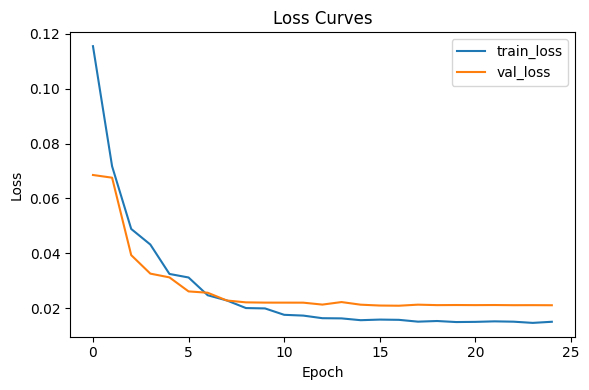

In [4]:
# Plot loss curves
from pioneerml.common.evaluation.plots.loss import LossCurvesPlot

if trained_module is None:
    raise RuntimeError("No trained module loaded from pipeline run.")

LossCurvesPlot().render(trained_module, show=True)
